# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [1]:
#!pip install keras
#import keras


#import nltk
#!pip install spacy
#import spacy

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#%timeit ,  line_profiler, memory_profiler

In [3]:
# Your code here
df = pd.read_csv('../data/boston_data.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

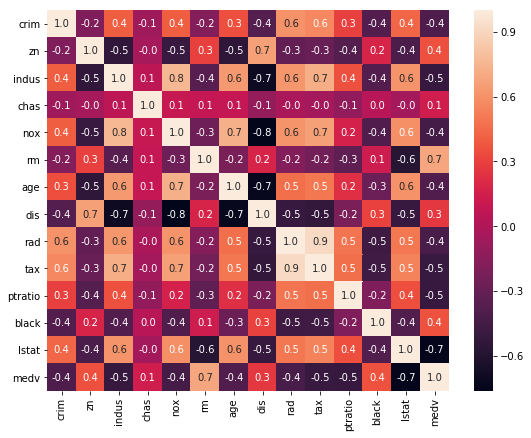

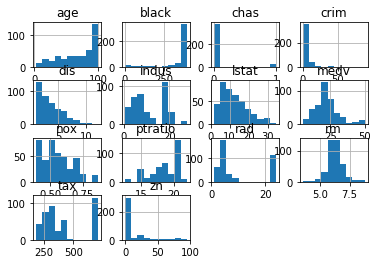

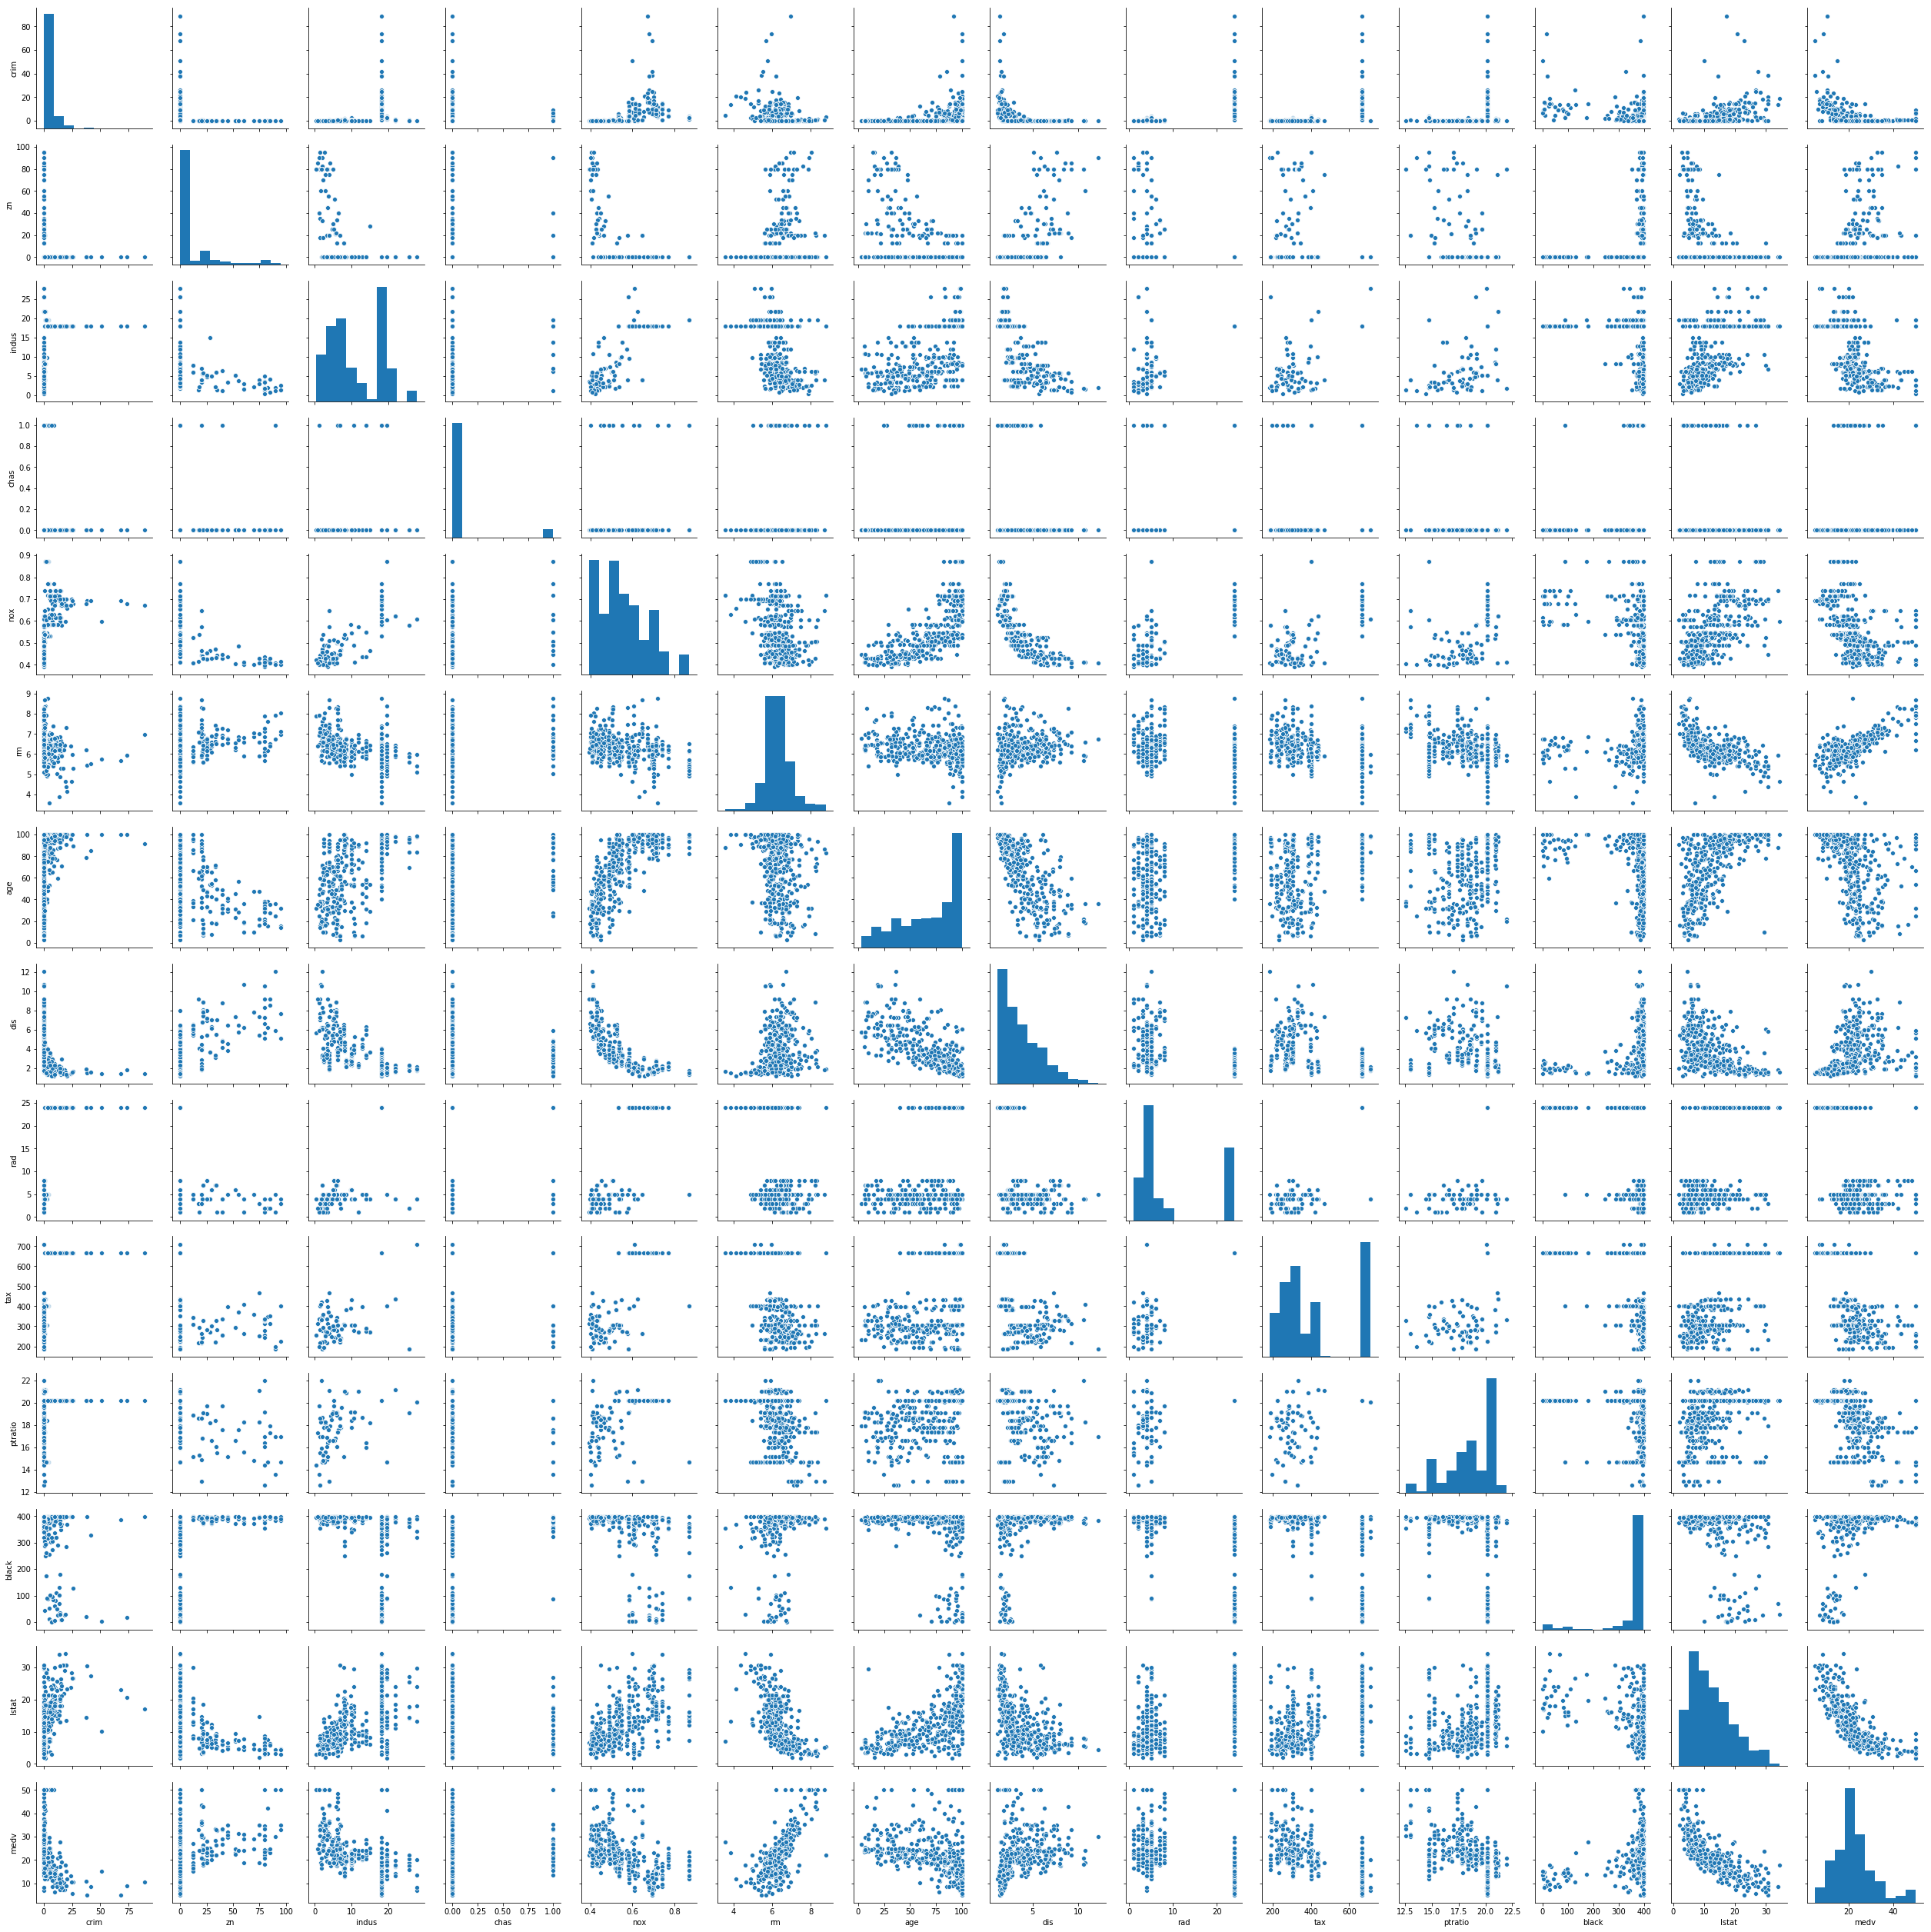

In [4]:
# Your plots here
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(df.corr(), annot=True,fmt="1.1f");

df.hist();
sns.pairplot(df);#, hue="location", vars=[POWER_SLAVE_PREFIX + f for f in features])

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [5]:
# Your response here
# m - medv
# m - lstat
# lstat - mdev
# nox - indus

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

In [6]:
# Your response here
df.isna().sum()
df.info()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
crim       404 non-null float64
zn         404 non-null float64
indus      404 non-null float64
chas       404 non-null float64
nox        404 non-null float64
rm         404 non-null float64
age        404 non-null float64
dis        404 non-null float64
rad        404 non-null float64
tax        404 non-null float64
ptratio    404 non-null float64
black      404 non-null float64
lstat      404 non-null float64
medv       404 non-null float64
dtypes: float64(14)
memory usage: 44.3 KB


### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [50]:
# Your code here
df.medv.describe()

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

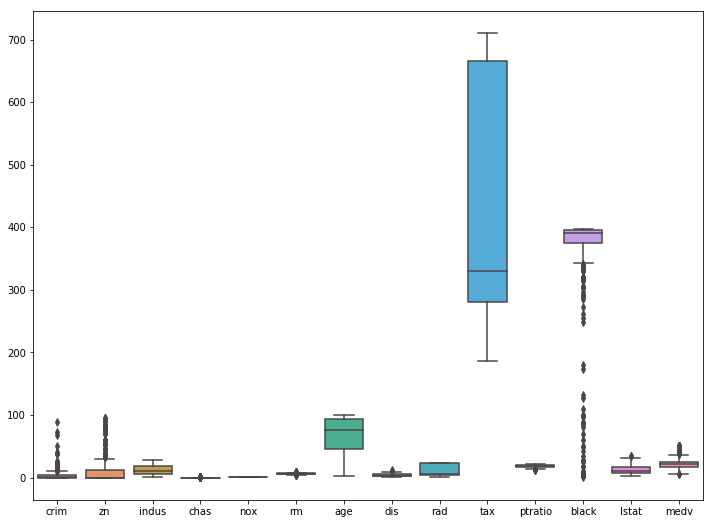

In [7]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=df);

In [8]:
def df_without_outliers(df, column):
    q1 = np.percentile(df[column], 25)
    q3 = np.percentile(df[column], 75)
    iqr = q3 - q1
    upper_fence = q3 + 3 * iqr
    lower_fence = q1 - 3 * iqr
    
    df_nu = df[df[column] < upper_fence]
    df_nl = df_nu[df_nu[column] > lower_fence]
    return df_nl

In [9]:
no_outliers = df_without_outliers(df, 'black')
no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 403
Data columns (total 14 columns):
crim       357 non-null float64
zn         357 non-null float64
indus      357 non-null float64
chas       357 non-null float64
nox        357 non-null float64
rm         357 non-null float64
age        357 non-null float64
dis        357 non-null float64
rad        357 non-null float64
tax        357 non-null float64
ptratio    357 non-null float64
black      357 non-null float64
lstat      357 non-null float64
medv       357 non-null float64
dtypes: float64(14)
memory usage: 41.8 KB


In [10]:
target = no_outliers['medv']
no_outliers = no_outliers.iloc[:,:-1]

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaled = MinMaxScaler(feature_range = (0, 1)).fit_transform(no_outliers.values)
df_no = pd.DataFrame(scaled, index=no_outliers.index, columns=no_outliers.columns)

In [12]:
no_outliers.head()
df_no.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.001713,0.000000,0.379399,0.0,0.043841,0.459858,0.150360,0.375837,0.130435,0.225191,0.702128,0.757355,0.280261
1,0.001090,0.263158,0.171188,0.0,0.127349,0.453344,0.456231,0.525937,0.304348,0.185115,0.755319,1.000000,0.257565
2,0.003856,0.000000,0.346041,0.0,0.317328,0.461966,0.760041,0.176447,0.130435,0.223282,0.617021,0.991977,0.283356
3,0.030658,0.000000,0.700880,0.0,1.000000,0.390113,0.947477,0.032544,0.173913,0.412214,0.223404,0.452346,0.678129
4,0.000416,0.221053,0.189883,0.0,0.098121,0.489366,0.618950,0.515232,0.130435,0.106870,0.446809,0.964381,0.264787


----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [13]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true,y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [46]:
# Your code here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_no, target, test_size= 0.2, shuffle=True, random_state=42)


----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [47]:
# Five separate RFR here with the given max depths
from sklearn.ensemble import RandomForestRegressor

def getRFR(depth, X_train, y_train):
    regr = RandomForestRegressor(max_depth=depth)
    regr.fit(X_train, y_train)  
    #y_pred = regr.predict(X_test)
    return regr.score(X_test, y_test)

def getYRFR(depth, X_train, y_train):
    regr = RandomForestRegressor(max_depth=depth)
    regr.fit(X_train, y_train)  
    return regr.predict(X_test)

Now, plot the score for each tree on the training set and on the testing set.

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

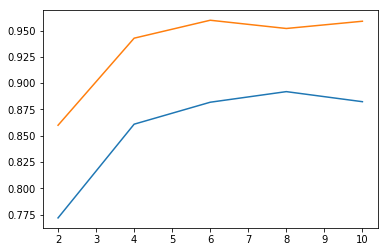

In [48]:
# Produce a plot with the score for the testing and training for the different max depths
li=[]
test=[]
for f in [2,4,6,8,10]:
    li.append(getRFR(f,X_train, y_train))
    test.append(getRFR(f,X_test, y_test))

li

plt.plot([2,4,6,8,10],li);#, label=key,color='blue');
plt.plot([2,4,6,8,10], test);#, label=key,color='orange');

#plt.legend()
plt.show();

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [17]:
# Your response here
# No es troba overfitting ni underfitting

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [51]:
# Your response here
yd1 = getYRFR(1,X_train, y_train)
yd10 = getYRFR(10,X_train, y_train)


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


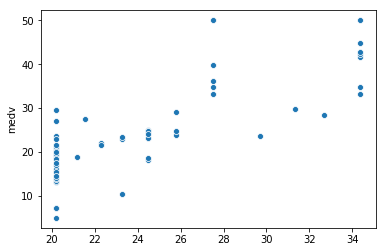

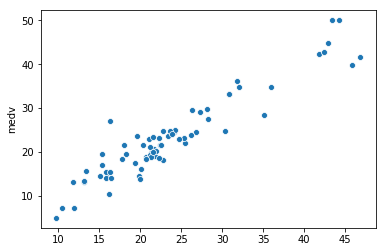

In [52]:
sns.scatterplot(x=yd1,y=y_test);
plt.show();
sns.scatterplot(x=yd10,y=y_test);
plt.show();
# veiem que hi ha mes variancia a depth=1, però 

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [19]:
# Your response here

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [20]:
# Your response here